# INF-0044 – Generative Adversarial Networks
## Trabalho Prático

Profa. Sandra Avila (sandra@ic.unicamp.br)

Monitor: Gabriel Oliveira (g197460@dac.unicamp.br)


## Objetivo 
Neste trabalho iremos utilizar uma Rede Generativa Adversarial Condicional (*Conditional* GAN) para gerar dígitos de casas a partir do *dataset* SVHN ([Street View House Numbers](http://ufldl.stanford.edu/housenumbers)).

## Conditional GANs
GANs são formadas por duas redes (discriminador e gerador) que são treinadas simultaneamente, sem compartilhamento de pesos. O gerador é responsável por aprender a transformar um ruído aleatório em uma imagem do *dataset* de interesse, enquanto o discriminador é responsável por classificar as imagens em reais e sintéticas (geradas). Um dos grandes problemas dos modelos GANs é a falta de controle quanto aos dados gerados. 

Assim, com o objetivo de controlar o tipo de dado gerado, [Mirza et al.](https://arxiv.org/abs/1411.1784) propuseram as Redes Generativas Adversariais Condicionais. Nesse tipo de rede, o módulo gerador e o discriminador são condicionados a alguma informação extra (*e.g.*, as anotações, outra modalidade de dado), como ilustrado na Figura 1. Podemos observar que a informação condicionante ($y$) deve ser concatenada de alguma forma às entradas do gerador e do discriminador. Neste trabalho, utilizaremos a própria anotação dos dados como variável condicionante.

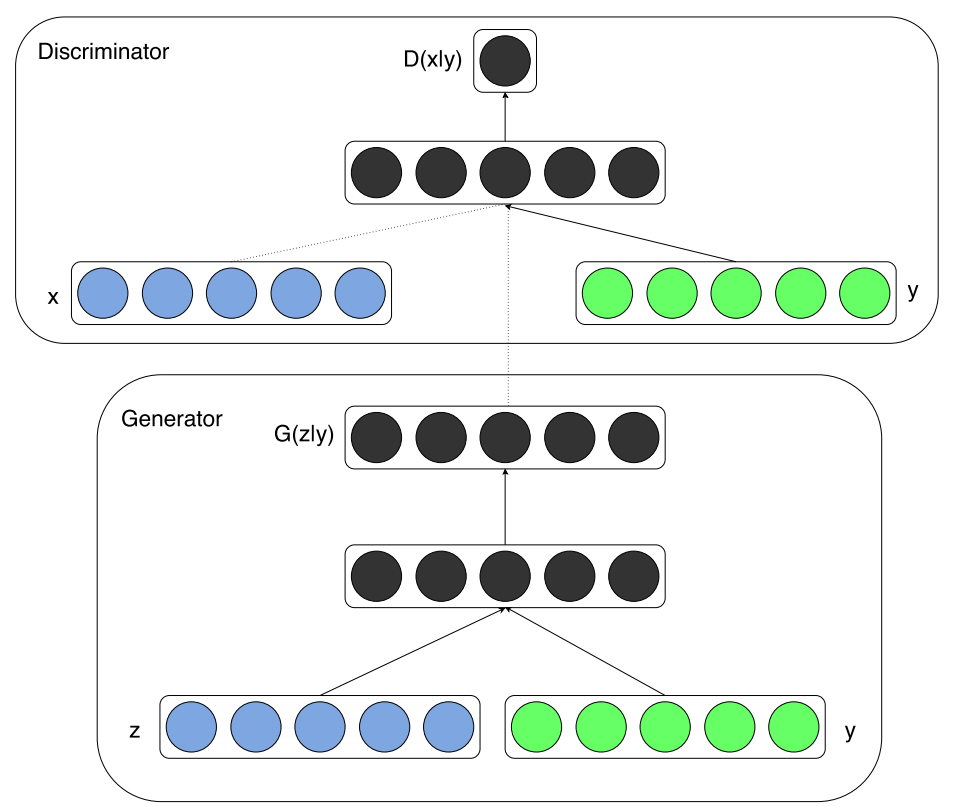

**Figura 1**: Visão geral da arquitetura das Redes Generativas Adversariais Condicionais.

## Dataset: SVHN

O *dataset* SVHN contém imagens de números de casas, já separadas (cortadas) por dígito, extraídas do Google Street View (Figura 2). O SVHN possui 73.257 imagens de treino, e 26.032 de teste, contando com 10 classes (uma para cada dígito). Para esta tarefa, faremos uma avaliação qualitativa das imagens geradas. Portanto, não utilizaremos o conjunto de teste, _apenas o conjunto de treino_. Como o SVHN é um conjunto bastante usado na literatura, ele está incorporado no `torchvision.datasets`. Assim, podemos usá-lo de maneira bastante similar ao MNIST visto nas aulas, veja a [documentação](https://pytorch.org/vision/stable/generated/torchvision.datasets.SVHN.html).

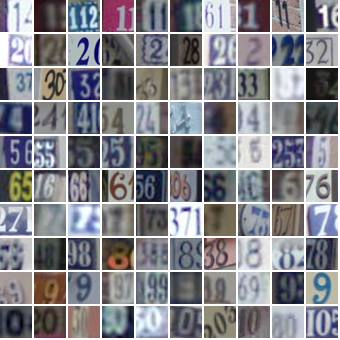

**Figura 2:** Classes e exemplos do *dataset SVHN*, cada uma em uma linha da imagem. Figura reproduzida de http://ufldl.stanford.edu/housenumbers/.

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import tqdm
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
train_dataset = torchvision.datasets.SVHN('./data', 
                              transform=torchvision.transforms.ToTensor(), 
                              download=True)


Using downloaded and verified file: ./data/train_32x32.mat


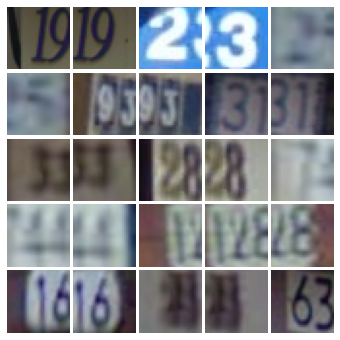

In [3]:
n = 5

fig = plt.figure(figsize=(6,6))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(n, n),
                 axes_pad=0.05)

for i, ax in enumerate(grid):
    img = train_dataset[i][0].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_axis_off()

plt.show()

## Atividades



1. (2.0 pontos) Altere a arquitetura apresentada na [Prática 2](https://drive.google.com/file/d/1oD7jeYD4tf33cXHGgkqL70rB3bSjem8x/view) para gerar imagens a partir do conjunto SVHN. 

* Plote a função de custo do gerador e do discriminador e o divergente de Jensen-Shannon ao longo das épocas;

* Ao final do treino, avalie a qualidade dos exemplos gerados usando a métrica Fréchet Inception Distance (FID);

* Plote um grid com alguns exemplos gerados.

Analise criticamente os resultados (Escreva 1-2 parágrafos sobre os resultados).

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision
import imageio
import numpy as np
import tqdm
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100
from mpl_toolkits.axes_grid1 import ImageGrid

In [5]:
# device = torch.device('mps')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dims):
        super(Generator, self).__init__()
        self.latent_dims = latent_dims
        self.net = nn.Sequential(
            nn.Linear(self.latent_dims, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 28*28),            
            nn.Tanh(),
        )
    def forward(self, x):
        return self.net(x).view(-1, 1, 28, 28)

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 32*32
        
        self.net = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self.net(x)

In [16]:
class VanillaGAN:
    def __init__(self, latent_dims, criterion):
        self.latent_dims = latent_dims
        self.generator = Generator(latent_dims)
        self.discriminator = Discriminator()
        
        self.criterion = criterion
            
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=3e-4)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=3e-4)
    

    def to(self, device):
        self.generator.to(device)
        self.discriminator.to(device)

    def train_discriminator(self, real_data, fake_data):
        batch_size = real_data.size(0)
        real_label = torch.ones(batch_size, 1).to(device) # real labels (1s)
        fake_label = torch.zeros(batch_size, 1).to(device) # fake labels (0s)

        self.optimizer_d.zero_grad()

        output_real = self.discriminator(real_data)
        loss_real = criterion(output_real, real_label)

        output_fake = self.discriminator(fake_data)
        loss_fake = criterion(output_fake, fake_label)

        loss_real.backward()
        loss_fake.backward()
        self.optimizer_d.step()

        return (loss_real + loss_fake) * 0.5


    def train_generator(self, fake_data):
        batch_size = fake_data.size(0)
        real_label = torch.ones(batch_size, 1).to(device) # real labels (1s)

        self.optimizer_g.zero_grad()

        output = self.discriminator(fake_data)
        loss = self.criterion(output, real_label)

        loss.backward()
        self.optimizer_g.step()

        return loss

In [17]:
# function to create the noise vector
def create_noise(sample_size, latent_dims):
    return torch.randn(sample_size, latent_dims).to(device)

In [18]:
def train(model, train_loader, epochs=20):
    log_dict = {"train_generator_loss": [],                
                "train_discriminator_loss": [],                
                "reconstructed_images":[]}
    
    for epoch in tqdm.notebook.tqdm(range(epochs)):
        loss_g = 0.0
        loss_d = 0.0
        model.discriminator.train()
        model.generator.train()
        for data in tqdm.notebook.tqdm(train_loader):
            image, _ = data
            image = image.to(device)
            batch_size = len(image)
            
            # train the discriminator network
            random_noise = create_noise(batch_size, model.latent_dims)
            fake_data = model.generator(random_noise).detach() # detach() prevents from training generator
            real_data = image            
            loss_d += model.train_discriminator(real_data, fake_data)

            # train the generator network
            random_noise = create_noise(batch_size, model.latent_dims)
            fake_data = model.generator(random_noise)
            loss_g += model.train_generator(fake_data)

        log_dict["train_generator_loss"].append(loss_g.item()/len(train_loader))
        log_dict["train_discriminator_loss"].append(loss_d.item()/len(train_loader))        
            
        log_dict["reconstructed_images"].append(fake_data.to('cpu').detach()[:5])
    log_dict["original_images"] = image.to('cpu').detach()[:5]
    
    return model, log_dict

In [19]:
criterion = nn.BCELoss()
latent_dims = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

model = VanillaGAN(latent_dims, criterion)
model.to(device)
model, log_dict = train(model, train_loader, epochs=300)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

: 

: 

2. (4.0 pontos) Com base na arquitetura implementada na questão 1, construa uma **GAN condicional** para gerar imagens condicionadas aos rótulos.

* Plote a função de custo do gerador e do discriminador e o divergente de Jensen-Shannon ao longo das épocas;

* Ao final do treino, avalie os exemplos gerados usando a métrica Fréchet Inception Distance (FID);

* Plote um grid com alguns exemplos gerados e seus respectivos rótulos.

Analise criticamente os resultados (Escreva 1-2 parágrafos sobre os resultados).

3. (4.0 pontos) Modifique a arquitetura implementada na questão 2 **adicionando camadas convolucionais**.

* Plote a função de custo do gerador e do discriminador e o divergente de Jensen-Shannon ao longo das épocas;

* Ao final do treino, avalie os exemplos gerados usando a métrica Fréchet Inception Distance (FID);

* Plote um grid com alguns exemplos gerados e seus respectivos rótulos.

Houve alguma melhoria em relação à arquitetura da questão 2? Analise criticamente os resultados (Escreva 1-2 parágrafos sobre os resultados).

##Prazo e Submissão

O trabalho é em dupla ou em trio e a entrega deve ser feita até dia 23/10/2022 (Domingo, 23h59). Apenas uma pessoa da equipe deve submeter o código no Jupyter Notebook.